# Medical Image Analysis workshop - IT-IST
## Image Quantification

### Statistics

In [15]:
import itk
import SimpleITK as sitk
import numpy as np
import itkwidgets as itkw
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats

In [2]:
image_T1_itk = itk.imread('./brain_T1.nii.gz')
mask_T1_itk = itk.imread('./bayesian_mask.nii.gz')

ITK also enables you to extract statistics of your images using your segmentation mask labels

In [3]:
label_stats_filter = itk.LabelStatisticsImageFilter[image_T1_itk, mask_T1_itk].New()
label_stats_filter.SetInput(image_T1_itk)
label_stats_filter.SetLabelInput(mask_T1_itk)
label_stats_filter.Update()

In [4]:
print('Label 1: min =', label_stats_filter.GetMinimum(1), '; max =', label_stats_filter.GetMaximum(1), '; mean =', label_stats_filter.GetMean(1), '; std =', label_stats_filter.GetSigma(1))
print('Label 2: min =', label_stats_filter.GetMinimum(2), '; max =', label_stats_filter.GetMaximum(2), '; mean =', label_stats_filter.GetMean(2), '; std =', label_stats_filter.GetSigma(2))
print('Label 3: min =', label_stats_filter.GetMinimum(3), '; max =', label_stats_filter.GetMaximum(3), '; mean =', label_stats_filter.GetMean(3), '; std =', label_stats_filter.GetSigma(3))
print('Label 4: min =', label_stats_filter.GetMinimum(4), '; max =', label_stats_filter.GetMaximum(4), '; mean =', label_stats_filter.GetMean(4), '; std =', label_stats_filter.GetSigma(4))

Label 1: min = 13.0 ; max = 585.0 ; mean = 255.19645583938166 ; std = 90.13731656157807
Label 2: min = 227.0 ; max = 786.0 ; mean = 435.6436780488756 ; std = 96.5742492892956
Label 3: min = 306.0 ; max = 982.0 ; mean = 598.7879315060999 ; std = 127.66366180056679
Label 4: min = 391.0 ; max = 1870.0 ; mean = 800.6032773863793 ; std = 141.234890668679


And making use of the interface ITK <-> Numpy you can go extend your analysis to whatever you may need.

This toy example shows you how to extract the image intensities corresponding to all for labels, display them in an histogram and perform statistical tests 

In [5]:
image_T1_np = itk.GetArrayFromImage(image_T1_itk)
mask_T1_np = itk.GetArrayFromImage(mask_T1_itk)

In [6]:
intensities_label_1 = image_T1_np[mask_T1_np == 1]
intensities_label_2 = image_T1_np[mask_T1_np == 2]
intensities_label_3 = image_T1_np[mask_T1_np == 3]
intensities_label_4 = image_T1_np[mask_T1_np == 4]

In [7]:
%matplotlib inline
bins = np.linspace(0, 1200, 100)

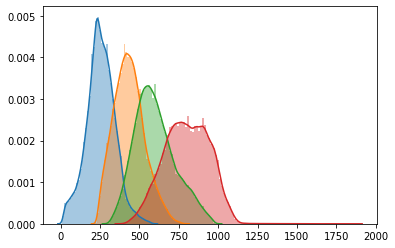

In [8]:
sns.distplot(intensities_label_1, bins=bins)
sns.distplot(intensities_label_2, bins=bins)
sns.distplot(intensities_label_3, bins=bins)
sns.distplot(intensities_label_4, bins=bins)

In [9]:
ks_test, p_value = stats.ks_2samp(intensities_label_3, intensities_label_2)
print('KS-test:', ks_test, '\np-value', p_value)

KS-test: 0.5304836452770536 
p-value 0.0


### MRI Parametric Maps
#### Making MRI quantitative

In this case we will use the .dcm files located in the Dwi_Brain folder. These are were acquired using a Diffusion Weighted sequence in which several volumes of the body part being studied are acquired with different b-values, allowing the computation of parametric maps [more on the method and clinical use](https://radiopaedia.org/articles/diffusion-weighted-imaging-1). 

The sequence contained in the Dwi_Brain folder contains 2(b=0 and b=1000) x 25 slices (3D volume), and we will use it to calculate the Apparent Diffusion Coefficient (ADC) parametric map.

\begin{equation*}
S_{b=1000} = S_{b=0} \cdot exp(-b \cdot ADC)
\end{equation*}
which can be rearranged to obtained the ADC as follows
\begin{equation*}
ADC = -\frac{ln(\frac{S_{b=1000}}{S_{b=0}})}{b}
\end{equation*}

The name of b-value dicom attribute is DiffusionBValue and the tag is (0018,9087). 

So first lets get all the .dcm files in the Dwi_Brain folder and separate them by b-value in order to create the $S_{b=0}$ and $S_{b=1000}$ volumes.

In [10]:
import os
import pydicom
dwi_dcm_dir = './Dwi_Brain'

## Get list of .dcm files in specified folder and ordered
namesGenerator = itk.GDCMSeriesFileNames.New()
namesGenerator.SetUseSeriesDetails(True)
namesGenerator.AddSeriesRestriction("0008|0021")
namesGenerator.SetGlobalWarningDisplay(False)
namesGenerator.SetDirectory(dwi_dcm_dir)

seriesUID = namesGenerator.GetSeriesUIDs()
dicom_names = namesGenerator.GetFileNames(seriesUID[0])
# dicom_names = [os.path.join(dwi_dcm_dir, file) for file in os.listdir(dwi_dcm_dir) if '.dcm' in file]

b0_dcms_list = []
b1000_dcms_list = []
for filename in dicom_names:
    if pydicom.dcmread(filename)[0x18,0x9087].value == 0:
        b0_dcms_list.append(filename)
    else:
        b1000_dcms_list.append(filename)

Using these two lists of .dcm files, corresponding to the two b-value, we can create the 3D $b_0$ and the $b_{1000}$ volumes.

In [11]:
# namesGenerator = itk.GDCMSeriesFileNames.New()
# namesGenerator.SetUseSeriesDetails(True)
# namesGenerator.AddSeriesRestriction("0008|0021")
# namesGenerator.SetGlobalWarningDisplay(False)
# namesGenerator.SetDirectory(dirName)

# seriesUID = namesGenerator.GetSeriesUIDs()

# if len(seriesUID) < 1:
#     print('No DICOMs in: ' + dirName)
#     sys.exit(1)

# print('The directory: ' + dirName)
# print('Contains the following DICOM Series: ')
# for uid in seriesUID:
#     print(uid)

# seriesFound = False
# for uid in seriesUID:
#     seriesIdentifier = uid
#     if len(sys.argv) > 3:
#         seriesIdentifier = sys.argv[3]
#         seriesFound = True
#     print('Reading: ' + seriesIdentifier)
#     fileNames = namesGenerator.GetFileNames(seriesIdentifier)

dicomIO = itk.GDCMImageIO.New()

reader_itk = itk.ImageSeriesReader[itk.Image.F3].New()
reader_itk.SetImageIO(dicomIO)
reader_itk.SetFileNames(b0_dcms_list)
reader_itk.ForceOrthogonalDirectionOff()
reader_itk.Update()

b0_image = reader_itk.GetOutput()

## We can reuse an instanciated filter
reader_itk2 = itk.ImageSeriesReader[itk.Image.F3].New()
reader_itk2.SetImageIO(dicomIO)
reader_itk2.ForceOrthogonalDirectionOff()
reader_itk2.SetFileNames(b1000_dcms_list)
reader_itk2.Update()
b1000_image = reader_itk2.GetOutput()

itkw.checkerboard(b0_image, b1000_image, cmap='Grayscale', mode='z', pattern=6)

Now, using both images and filters we can compute the ADC parametric map

In [12]:
b = 1000.0 # s/mm²

division_filter = itk.DivideImageFilter[itk.Image.F3, itk.Image.F3, itk.Image.F3].New()
division_filter.SetInput1(b1000_image)
division_filter.SetInput2(b0_image)
division_filter.Update()

b1000_div_b0_image = division_filter.GetOutput()

log_filter = itk.LogImageFilter[itk.Image.F3, itk.Image.F3].New()
log_filter.SetInput(b1000_div_b0_image)
log_filter.Update()

ln_b1000_div_b0_image = log_filter.GetOutput()

division_filter2 = itk.DivideImageFilter[itk.Image.F3, itk.Image.F3, itk.Image.F3].New()
division_filter2.SetInput1(ln_b1000_div_b0_image)
division_filter2.SetConstant2(-1. * b / 1e6) # 10−6 mm2 /s
division_filter2.Update()

ADC_image = division_filter2.GetOutput()

## infinit values will prevent us from correctly view the image so we will have to threshold it
threshold_filter = itk.ThresholdImageFilter[itk.Image.F3].New()
threshold_filter.SetInput(ADC_image)
threshold_filter.SetLower(0.0)
threshold_filter.SetUpper(6000.0)
threshold_filter.SetOutsideValue(0.)
threshold_filter.Update()

ADC_image = threshold_filter.GetOutput()

itkw.view(ADC_image, cmap='Grayscale', mode='z')

Viewer(cmap='Grayscale', geometries=[], gradient_opacity=0.22, mode='z', point_sets=[], rendered_image=<itkIma…

#### Exercise 2

Using the lists **b0_dcms_list** and **b1000_dcms_list** use the SimpleITK **ImageSeriesReader** function to read the **b0** and **b1000** images and then use **/** and * to perform the division and multiplication operations

In [13]:
## use this code box to write your solution



In [18]:




















reader_b0 = sitk.ImageSeriesReader()
reader_b0.SetFileNames(b0_dcms_list)
b0_image = reader_b0.Execute()

reader_b1000 = sitk.ImageSeriesReader()
reader_b1000.SetFileNames(b1000_dcms_list)
b1000_image = reader_b1000.Execute()

b1000_div_b0_image = b1000_image/b0_image

log_b1000_div_b0_image = sitk.Log(b1000_div_b0_image)

adc_image = log_b1000_div_b0_image/(-1. * b / 1e6)

adc_image = sitk.Threshold(adc_image, lower=0, upper=6000, outsideValue=0)

itkw.view(ADC_image, cmap='Grayscale', mode='z')

Viewer(cmap='Grayscale', geometries=[], gradient_opacity=0.22, mode='z', point_sets=[], rendered_image=<itkIma…